In [1]:
import sys
import math
import numpy as np
from collections import defaultdict
from Bio import SeqIO, Seq, SeqRecord
import pickle
from icecream import ic

In [2]:
class Modification:
    '''
    Class to represent a modification
    '''
    def __init__(self, position, calling):
        self.position = position
        self.calling = calling

In [3]:
class BED:
    '''
    Class to represent an entry in a BED file
    '''
    def __init__(self, chro, start, end, quality, strand):
        self.chro = chro
        self.start = start
        self.end = end
        self.quality = quality
        self.strand = strand

# Functions

In [4]:
def build_modification_map(f,emat):
    import random
    mod_map = defaultdict(list)
    read_dict = {}
    ct = 0
    read = ''
    edits = []
    groundTruth = ''
    aPositions = []

    for line in f:
        line = line.rstrip()
        # print(line)
        if line.startswith('read_'):
            read += line
            ct += 1
        elif ct == 1:
            edits = [int(i) for i in line]
            ct += 1
        elif ct == 2:
            groundTruth = line
            ct += 1
        elif ct == 3:
            aPositions = [int(i) for i in line.split(',')]
            ct = 0
            read_dict[read] = (edits, groundTruth, aPositions)
            footprint_indices = [i for i, x in enumerate(groundTruth) if x == 'y'] 
            # Footprint_As = random.sample(footprint_indices, len(footprint_indices)//4)
            #### need to edit this so that all unedited A's are set to 0.03 ########
            # for i in range(len(edits)):
            #     if edits[i] != 0:
            #         mod_map[read].append(Modification(i, 0.97))
            #     elif i in Footprint_As:
            #         mod_map[read].append(Modification(i, 0.03))
            for i in aPositions:
                if edits[i] == 1:
                    mod_map[read].append(Modification(i, emat[0]))
                else:
                    mod_map[read].append(Modification(i, emat[1]))
                
                
            read = ''
            edits = []
            groundTruth = ''
            aPositions = []

    return mod_map, read_dict
            
        

In [5]:
def build_modification_map2(f):
    import random
    mod_map = defaultdict(list)
    read_dict = {}
    ct = 0
    read = ''
    edits = []
    groundTruth = ''
    aPositions = []

    for line in f:
        line = line.rstrip()
        # print(line)
        if line.startswith('read_'):
            read += line
            ct += 1
        elif ct == 1:
            edits = [int(i) for i in line]
            ct += 1
        elif ct == 2:
            groundTruth = line
            ct += 1
        elif ct == 3:
            aPositions = [int(i) for i in line.split(',')]
            ct = 0
            read_dict[read] = (edits, groundTruth, aPositions)
            for i in aPositions:
                if edits[i] == 1:
                    mod_map[read].append(Modification(i, 0.97))
                else:
                    mod_map[read].append(Modification(i, 0.03))
                
                
            read = ''
            edits = []
            groundTruth = ''
            aPositions = []

    return mod_map, read_dict
            
        

In [6]:
def make_calling_vector(mod_list, read_length):
    calling_vec = [-1] * (read_length + 1)

    for m in mod_list:
        position = m.position
        calling = m.calling
        if 0 <= position <= read_length:
            calling_vec[position] = calling

    return calling_vec

## Score Distribution

In [66]:
mod_file = '/data16/liam/testing/HMM_test_data_20.txt'

scores = {}
with open (mod_file) as mf:
    
    mod_map, read_dict = build_modification_map2(mf)
    for read, modList in mod_map.items():
        # check that edits and ground truth are same length
        # print(''.join(str(i) for i in read_dict[read][0]))
        # print(read_dict[read][1])
        assert len(read_dict[read][0]) == len(read_dict[read][1]), 'edits and ground truth are not the same length'

        s = [mod_map[read][i].calling for i in range(len(mod_map[read]))]
        scores[read] = [float(i) for i in s]

        

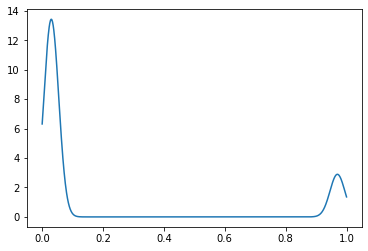

In [67]:
# plot score distribution 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

score_list = []
for read, score in scores.items():
    score_list += score

score_list = np.array(score_list)
kde = gaussian_kde(score_list)



dist_space = linspace( 0, 1, 1000 )

plt.plot( dist_space, kde(dist_space) )




In [68]:
# vectorize kde function
vector = kde(dist_space)
print(len(vector))

1000


In [69]:
# write vector to file
with open('/data16/liam/testing/kde_vector_20.txt', 'w') as f:
    for i in vector:
        f.write(str(i) + '\n')

### Score Distribution of Tad Accessible/Unaccessible Regions
#### with lower editing rates, the HMM tends to overpredict shadows. One idea we have is to introduce a tad accessibility score for kmers. This will enable us to enable multiple paths that we can iterate through with dynamic programming/backtracking algorithms to find the optimal path of shadows.
#### in real data, the accessibility score will likely be a measurement of base editor sequence preference, number of A's in kmer, and number of edits in kmer (in shadowless data)
#### in simulated data, I will just use number of As in kmer

In [70]:
# reads = '/data16/liam/testing/HMM_test_data_AC50.txt'
reads = '/data16/liam/testing/HMM_test_data_20.txt'
tad_access_scores = {}
with open(reads) as f:
    mod_map, read_dict = build_modification_map2(f)
    for read in read_dict:
        kmer_dict = {}
        for i in range(len(read_dict[read][0])-6):
            kmer = read_dict[read][0][i:i+6]
            # count number of A's in kmer
            num_A = 0
            for base in range(len(kmer)):
                if i + base in read_dict[read][2]:
                    num_A += 1

            # calculate TAD access score
            tad_access_score = num_A / len(kmer)
            # calculate TAD inaccess score
            tad_inaccess_score = (len(kmer) - num_A) / len(kmer) 

            # kmer_name = ''.join(str(i) for i in kmer)
            kmer_name = str(i) + '_' + str(i+6)
            if kmer_name not in kmer_dict:
                kmer_dict[kmer_name] = (tad_access_score, tad_inaccess_score)
            # else:
            #     kmer_dict[kmer_name] = (kmer_dict[kmer_name][0] * tad_access_score, kmer_dict[kmer_name][1] * tad_inaccess_score)

        tad_access_scores[read] = kmer_dict
            

In [71]:
# write to pickle
import pickle
with open('/data16/liam/testing/tad_access_scores_20.pkl', 'wb') as f:
    pickle.dump(tad_access_scores, f)

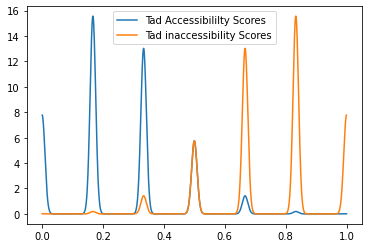

In [ ]:
# plot score distribution 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

access_scores = []
inaccess_scores = []
for read in tad_access_scores:
    for kmer in tad_access_scores[read]:
        access_scores.append(tad_access_scores[read][kmer][0])
        inaccess_scores.append(tad_access_scores[read][kmer][1])


access_scores = np.array(access_scores)
inaccess_scores = np.array(inaccess_scores)

kde = gaussian_kde(access_scores)
kde2 = gaussian_kde(inaccess_scores)


dist_space = linspace( 0, 1, 1000 )

plt.plot( dist_space, kde(dist_space) )
plt.plot( dist_space, kde2(dist_space) )
plt.legend(['Tad Accessibililty Scores', 'Tad inaccessibility Scores'])




# Build Transition and Probability Matrices

### HMM with emission matrix from score distribution

In [72]:
# mod_file = '/data16/liam/testing/HMM_test_data_10.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_pred_10_kde.txt'

# emission_pos_file = '/data16/liam/testing/kde_vector_10.txt'
# emission_neg_file = '/data16/liam/testing/kde_vector_mock.txt'
mod_file = '/data16/liam/testing/HMM_test_data_20.txt'
pred_file = '/data16/liam/testing/241210_HMM_test_data_pred_20_kde.txt'

emission_pos_file = '/data16/liam/testing/kde_vector_20.txt'
emission_neg_file = '/data16/liam/testing/kde_vector_mock.txt'

emission_pos_array = []
with open(emission_pos_file) as f:
    for line in f:
        emission_pos_array.append(float(line.rstrip()))
emission_pos_array = np.array(emission_pos_array)
emission_neg_array = []
with open(emission_neg_file) as f:
    for line in f:
        emission_neg_array.append(float(line.rstrip()))
emission_neg_array = np.array(emission_neg_array)

# get access scores from pickle
with open('/data16/liam/testing/tad_access_scores_20.pkl', 'rb') as f:
    tad_access_scores = pickle.load(f)

In [73]:
outDict = {}
with open (mod_file) as mf:
    with open(pred_file, 'w') as pf:
        mod_map, read_dict = build_modification_map2(mf)
        
        
        for read, modList in mod_map.items():
            # check that edits and ground truth are same length
            assert len(read_dict[read][0]) == len(read_dict[read][1]), 'edits and ground truth are not the same length'

            read_length = len(read_dict[read][0])
            calling_vec = make_calling_vector(modList, read_length) 

            # initialize probability matrix
            prob_mat = np.array([[0.0] * 31 for _ in range(read_length+1)]) 
            
            # initialize pointer matrix
            ptr_mat = np.array([[-1] * 31 for _ in range(read_length+1)])
        

            initial_rate = 1 / 31.0
            log_initial_rate = math.log(initial_rate)


            for j in range(0,31):
                # initialize initial probability
                prob_mat[1][j] = log_initial_rate
                ptr_mat[1][j] = 0

            for i in range(1, read_length+1): # changed to 1, read_length+1 from 2, read_length + 1
                within_linker = 0.0
                back_frm_ribosome = 0.0

                kmer = str(i-1) + '_' + str(i+5)
                if kmer in tad_access_scores[read]:
                    tad_access_score = tad_access_scores[read][kmer][0]
                    tad_inaccess_score = tad_access_scores[read][kmer][1]
                else:
                    tad_access_score = 0.5
                    tad_inaccess_score = 0.5
                    
                a_score = math.log(tad_access_score) if tad_access_score != 0 else 0
                i_score = math.log(tad_inaccess_score) if tad_inaccess_score != 0 else 0
                # if i is not an A
                if calling_vec[i] == -1: # calling vector is -1 at non A positions
                    # within linker probability is same as previous
                    within_linker = prob_mat[i-1][0]
                    # if not in first row of matrix
                    if prob_mat[i-1][30] != 0:
                        back_frm_ribosome = prob_mat[i-1][30] 

                else:
                    # i is an A
                    k = int(calling_vec[i] * 1000)
                    # within_linker = log_norm_density(calling_vec[i], k, emission_pos_array) + prob_mat[i-1][0]
                    # within_linker = math.log(emission_pos_array[k]) + prob_mat[i-1][0] - i_score 
                    within_linker = math.log(emission_pos_array[k]) + prob_mat[i-1][0] # use this line with 80% data
                    if prob_mat[i-1][30] != 0:
                        # back_frm_ribosome = log_norm_density(calling_vec[i], k, emission_pos_array) + prob_mat[i-1][30]
                        back_frm_ribosome = math.log(emission_pos_array[k]) + a_score + prob_mat[i-1][30]
                        
                #if probability that we are in the footprint is greater than the probability that we are in the linker
                if back_frm_ribosome != 0 and back_frm_ribosome > within_linker:
                    prob_mat[i][0] = back_frm_ribosome
                    ptr_mat[i][0] = 30 #update pointer matrix
                # if the probability that the previous nucleotide was in the linker is greater
                else:
                    prob_mat[i][0] = within_linker
                    ptr_mat[i][0] = 0

                if calling_vec[i] == -1:
                    prob_mat[i][1] = prob_mat[i - 1][0]
                else:
                    k = int(calling_vec[i] * 1000)
                    # prob_mat[i][1] = log_norm_density(calling_vec[i], k, emission_neg_array) + prob_mat[i - 1][0]
                    prob_mat[i][1] = math.log(emission_neg_array[k]) + a_score + prob_mat[i - 1][0] 
                ptr_mat[i][1] = 0

                for j in range(2, 31):
                    if calling_vec[i] == -1:
                        if prob_mat[i-1][j-1] != 0:
                            prob_mat[i][j] = prob_mat[i-1][j-1]
                    else:
                        k = int(calling_vec[i] * 1000)
                        # k = 3
                        if prob_mat[i-1][j-1] != 0:
                            # prob_mat[i][j] = log_norm_density(calling_vec[i], k, emission_neg_array) + prob_mat[i-1][j-1]
                            prob_mat[i][j] = math.log(emission_neg_array[k]) + a_score + prob_mat[i-1][j-1]
                    if prob_mat[i][j] != 0:
                        ptr_mat[i][j] = j-1
            
            # set max probability to super low number
            max_prob = -10000000.0
            # set max index to -1, which will be used to index the backtrack vector
            max_index = -1
            # iterate through the last row of the probability matrix to find the max probability
            for j in range(31):
                # if the probability of the last nucleotide being in the ribosome is greater than the max probability
                if prob_mat[read_length][j] > max_prob:
                    # set the max probability to the probability of the last nucleotide being in the ribosome
                    max_prob = prob_mat[read_length][j]
                    # set the max index to the index of the last nucleotide being in the ribosome
                    max_index = j
            
            # initialize backtrack vector
            backtrack_vec = []
            # for i in range(read_length, 0, -1):
            for i in range(len(ptr_mat)-1, 0, -1):
                # append the max index to the backtrack vector
                backtrack_vec.append(max_index) 
                # set the max index to the index of the previous nucleotide
                max_index = ptr_mat[i-1][max_index] # added ptr_mat[i-1][max_index] instead of ptr_mat[i][max_index], Dec 21, 2023
            # reverse the backtrack vector
            backtrack_vec.reverse()
            
            pred = ''
            # LT adding confidence score, 12/5/24
            confidence = 0
            
            for i in range(len(backtrack_vec)):
                if backtrack_vec[i] > 0:
                    pred += 'y'
                else:
                    pred += 'x'


            if len(pred) != len(read_dict[read][1]):
                print('prediction and ground truth are not the same length')
                print('pred: ')
                print(pred)
                print('true: ')
                print(read_dict[read][1])
                sys.exit()
            outDict[read] = [pred, read_dict[read][1]]



            #### write prediction to file ####
            pf.write(read + '\n')
            pf.write('pred:' + '\n')
            pf.write(pred + '\n')
            pf.write('true:' + '\n')
            pf.write(read_dict[read][1] + '\n')
            pf.write('modifications:' + '\n')
            pf.write(''.join(str(i) for i in read_dict[read][0]) + '\n')
            pf.write('a_positions:' + '\n')
            pf.write(','.join(str(i) for i in read_dict[read][2]) + '\n') # added 12/5/24 to print a_positions

### write transition matrix to file ####
with open('/data16/liam/testing/transition_mat.txt', 'w') as tm:
    tm.write('read_length: ' + str(len(read_dict[read][1])) + '\t' + 'prediction_length: ' + str(len(pred)) + '\t' + 
             'matrix_length: ' + str(ptr_mat.shape[0]) + '\t'+ 'backtrack_vec: ' + str(len(backtrack_vec)) + '\n')
    tm.write(read)
    tm.write('\n')
    tm.write('\t'.join(str(i) for i in ptr_mat[0]))
    tm.write('\n')
    tm.write('\t'.join(str(i) for i in ptr_mat[1]) + '\t' + str(calling_vec[0]) + '\t' + read_dict[read][1][0] + '\t' + pred[0] + '\t' + str(backtrack_vec[0]))
    tm.write('\n')
    for j in range(1, len(ptr_mat)):
        tm.write('\t'.join(str(i) for i in ptr_mat[j]) + '\t' + str(calling_vec[j]) + '\t' + read_dict[read][1][j-1] + '\t' + pred[j-1] + '\t' + str(backtrack_vec[j-1]))
        tm.write('\n')

### write probability matrix to file ####
with open('/data16/liam/testing/probability_mat.txt','w') as pm:
    pm.write('read_length: ' + str(len(read_dict[read][1])) + '\t' + 'prediction_length: ' + str(len(pred)) + '\t' + 
             'matrix_length: ' + str(prob_mat.shape[0]) + '\t' + 'backtrack_vec: ' + str(len(backtrack_vec)) + '\n')
    pm.write(read)
    pm.write('\n')
    pm.write('\t'.join(str(i) for i in prob_mat[0]))
    pm.write('\n')
    pm.write('\t'.join(str(i) for i in prob_mat[1]) + '\t' + str(calling_vec[0]) + '\t' + read_dict[read][1][0] + '\t' + pred[0] + '\t' + str(backtrack_vec[0]))
    pm.write('\n')
    for j in range(1, len(prob_mat)):
        pm.write('\t'.join(str(i) for i in prob_mat[j]) + '\t' + str(calling_vec[j]) + '\t' + read_dict[read][1][j-1] + '\t' + pred[j-1] + '\t' + str(backtrack_vec[j-1]))
        pm.write('\n')


# ROC curve
## TPR is number of footprints in the correct location / ground truth footprints
## FPR is number of predicted footprints in the wrong location / number of incorrect location footprints + total predicted footprints

In [7]:
def parse_pred_file(filename):
    reads = []
    with open(filename, 'r') as file:
        while True:
            read_name = file.readline().strip()
            if not read_name:
                break
            file.readline()  # Skip 'pred:' line
            predicted_sequence = file.readline().strip()
            file.readline()  # Skip 'true:' line
            true_sequence = file.readline().strip()
            file.readline()  # Skip 'modifications:' line
            modifications = file.readline().strip()
            file.readline()
            a_positions = file.readline().strip()
            
            reads.append((read_name, predicted_sequence, true_sequence, modifications, a_positions))
    return reads

In [8]:
def get_all_footprint_indices(data, footprint_char='y'):
    '''
    This function returns a list of tuples containing the start and end indices of all footprints in the data
    '''
    footprints = []
    start_index = None

    for i in range(len(data)):
        if data[i] == footprint_char and start_index is None:
            start_index = i
        elif data[i] != footprint_char and start_index is not None:
            footprints.append((start_index, i - 1))
            start_index = None

    if start_index is not None:
        footprints.append((start_index, len(data) - 1))

    return footprints

In [9]:
def calculate_overlap(predicted_start, predicted_end, ground_truth_start, ground_truth_end):
    '''
    calculates the overlap between two footprints
    '''
    overlap_start = max(predicted_start, ground_truth_start)
    overlap_end = min(predicted_end, ground_truth_end)
    
    if overlap_end >= overlap_start:
        overlap = overlap_end - overlap_start + 1
    else:
        overlap = 0
    
    return overlap

In [10]:
def get_true_positives(predicted_footprints, true_footprints, confidence_dict, threshold):
    '''
    This function returns the number of true positives. True positives are defined as predicted footprints that overlap with true footprints
    '''
    true_positives = 0
    false_positives = 0 # if a true positive confidence score < threshold, it is a false positive
    TPs = []
    for predicted_footprint in predicted_footprints:
        for true_footprint in true_footprints:
            overlap = calculate_overlap(predicted_footprint[0], predicted_footprint[1], true_footprint[0], true_footprint[1])
            if overlap > 0 and confidence_dict[predicted_footprint] > threshold:
                true_positives += 1
                # TPs.append(predicted_footprint)
                break
            # elif overlap > 0 and confidence_dict[predicted_footprint] < threshold:
            #     false_positives += 1
         
    return true_positives

def get_false_positives(predicted_footprints, true_footprints, confidence_dict, threshold):
    '''
    This function returns the number of false positives. False positives are defined as predicted footprints that do not overlap with true footprints or if the confidence score is less than the threshold
    '''
    false_positives = 0
    FPs = []
    for predicted_footprint in predicted_footprints:
        # is_false_positive = True
        # for true_footprint in true_footprints:
        #     if confidence_dict[predicted_footprint] < threshold:
        #         false_positives += 1
        #         FPs.append(predicted_footprint)
        #         break
        #     else:
        #         overlap = calculate_overlap(predicted_footprint[0], predicted_footprint[1], true_footprint[0], true_footprint[1])
        #         if overlap > 0:
        #             is_false_positive = False
        #             break
        #         else:
        #             false_positives += 1

        is_false_positive = True
        for true_footprint in true_footprints:
            overlap = calculate_overlap(predicted_footprint[0], predicted_footprint[1], true_footprint[0], true_footprint[1])
            if overlap > 0 and confidence_dict[predicted_footprint] > threshold: # true positive
                is_false_positive = False
                break

        if is_false_positive and confidence_dict[predicted_footprint] > threshold:
            false_positives += 1
        

    return false_positives

def get_false_negatives(predicted_footprints, true_footprints):
    '''
    This function returns the number of false negatives. False negatives are defined as true footprints that do not overlap with predicted footprints
    '''
    false_negatives = 0

    for true_footprint in true_footprints:
        is_false_negative = True
        for predicted_footprint in predicted_footprints:
            overlap = calculate_overlap(predicted_footprint[0], predicted_footprint[1], true_footprint[0], true_footprint[1])
            if overlap > 0:
                is_false_negative = False
                break

        if is_false_negative:
            false_negatives += 1

    return false_negatives

def get_true_negatives(predicted_sequence, true_sequence, footprint_char='y'):
    '''
    True negatives are defined as positions where there are no footprints in both the true sequence and the predicted sequence
    '''
    true_negatives = 0
    for i in range(len(predicted_sequence)):
        if predicted_sequence[i] != footprint_char and true_sequence[i] != footprint_char:
            true_negatives += 1

    return true_negatives
    
    

In [11]:
# Dec 6, 2024
def p_ribosome(predicted_sequence, a_positions, mod_frequency, footprint_char='y'):
    '''
    This function calculates the confidence of the ribosome prediction. Confidence is a function of modification frequency and if there are any A's in the footprint.
    We don't want this to be function of ground truth because in practice we won't have that information.

    Parameters:
    predicted_sequence: str
    footprint_char: str
    a_positions: list of int

    Output: {read_name: [ribosome_position, confidence]}
    scores (str): new string with confidence scores for each ribosome position
    '''
    footprint_indices = get_all_footprint_indices(predicted_sequence, footprint_char)
    read_predictions = {}
    a_positions = [int(i) for i in a_positions[0].split(',')]
    scores = []
        
    for ribosome in footprint_indices:
        f_st, f_end = ribosome
        a_in_footprint = False
        a_ct = 0
        # ic(f_st, f_end)
        
        for i in range(f_st, f_end+1):
            if i in a_positions:
                a_in_footprint = True
                a_ct += 1

        if a_in_footprint:
            # confidence = (a_ct / (f_end - f_st + 1)) * mod_frequency
            confidence = a_ct * mod_frequency

        else:
            confidence = 0.03 * mod_frequency

        # read_predictions[f'{f_st}_{f_end}'] = [ribosome, confidence]
        read_predictions[ribosome] = confidence

    scores = list(predicted_sequence)
    # replace x's with 0's
    scores = [0 if i == 'x' else i for i in scores]
    # replace y's with footprint confidence scores
    for ribosome, confidence in read_predictions.items():
        for i in range(ribosome[0], ribosome[1]+1):
            scores[i] = confidence



    return read_predictions, scores

In [12]:
reads_100 = parse_pred_file('/data16/liam/testing/241205_HMM_test_data_pred_30only_kde.txt')

### trying this with sklearn - December 10, 2024

In [13]:
test_read = reads_100[0]
read_name = test_read[0]
predicted_sequence = test_read[1]
true_sequence = test_read[2]
modifications = test_read[3]
a_positions = test_read[4]

read_predictions, scores = p_ribosome(predicted_sequence, [a_positions], 1.0)
# cool, seems to work

In [14]:
pred_dict = {}
plot_dict_100 = {}
for read in reads_100:
    # ic(read[1], read[4])
    read_dict, scores = p_ribosome(read[1], [read[4]], 1.0)
    plot_dict_100[read[0]] = [read[2], scores]
    pred_dict[read[0]] = read_dict
ic(pred_dict['read_0'])

ic| pred_dict['read_0']: {(103, 132): 9.0,
                          (409, 438): 8.0,
                          (609, 638): 11.0,
                          (937, 966): 10.0,
                          (1154, 1183): 10.0,
                          (1453, 1482): 8.0,
                          (1812, 1841): 2.0,
                          (2093, 2122): 11.0,
                          (2304, 2333): 10.0,
                          (2615, 2644): 6.0,
                          (2847, 2876): 5.0,
                          (3179, 3208): 9.0,
                          (3395, 3424): 7.0,
                          (3681, 3710): 7.0}


{(103, 132): 9.0,
 (409, 438): 8.0,
 (609, 638): 11.0,
 (937, 966): 10.0,
 (1154, 1183): 10.0,
 (1453, 1482): 8.0,
 (1812, 1841): 2.0,
 (2093, 2122): 11.0,
 (2304, 2333): 10.0,
 (2615, 2644): 6.0,
 (2847, 2876): 5.0,
 (3179, 3208): 9.0,
 (3395, 3424): 7.0,
 (3681, 3710): 7.0}

In [15]:
reads_80 = parse_pred_file('/data16/liam/testing/241209_HMM_test_data_pred_80_kde.txt')
plot_dict_80 = {}
for read in reads_80:
    read_dict, scores = p_ribosome(read[1], [read[4]], 0.8)
    plot_dict_80[read[0]] = [read[2], scores]


In [16]:
reads_60 = parse_pred_file('/data16/liam/testing/241210_HMM_test_data_pred_60_kde.txt')
plot_dict_60 = {}
for read in reads_60:
    read_dict, scores = p_ribosome(read[1], [read[4]], 0.6)
    plot_dict_60[read[0]] = [read[2], scores]

In [17]:
reads_40 = parse_pred_file('/data16/liam/testing/241210_HMM_test_data_pred_40_kde.txt')
plot_dict_40 = {}
for read in reads_40:
    read_dict, scores = p_ribosome(read[1], [read[4]], 0.4)
    plot_dict_40[read[0]] = [read[2], scores]

In [18]:
reads_20 = parse_pred_file('/data16/liam/testing/241210_HMM_test_data_pred_20_kde.txt')
plot_dict_20 = {}
for read in reads_20:
    read_dict, scores = p_ribosome(read[1], [read[4]], 0.2)
    plot_dict_20[read[0]] = [read[2], scores]

Text(0.5, 1.0, 'Confidence Score Distribution for Ribosome Prediction')

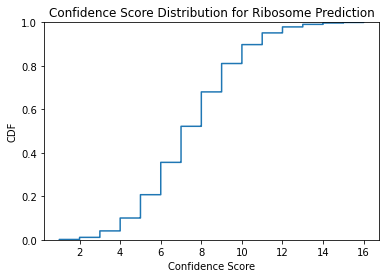

In [19]:
# plot distribution of confidence scores as CDF
import matplotlib.pyplot as plt
import seaborn as sns

confidence_scores = []
for read in pred_dict:
    for key in pred_dict[read]:
        confidence_scores.append(pred_dict[read][key])

# counts, bin_edges = np.histogram(confidence_scores, bins = 1000)
# pdf = counts/sum(counts)
# cdf = np.cumsum(pdf)
sns.ecdfplot(confidence_scores)
plt.xlabel('Confidence Score')
plt.ylabel('CDF')
plt.title('Confidence Score Distribution for Ribosome Prediction')


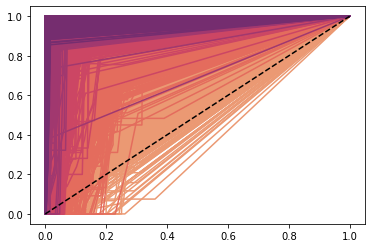

In [75]:
# testing sklearn ROC function
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc

ROC_dict = {}
libraries = [plot_dict_20, plot_dict_40, plot_dict_60, plot_dict_80, plot_dict_100]
colors = sns.color_palette("flare", len(libraries)*2)

for i in range(len(libraries)):
    for read in libraries[i]:
        pred = libraries[i][read][1]
        true = libraries[i][read][0]
        true = [1 if i == 'y' else 0 for i in true]
        # RocCurveDisplay.from_predictions(true, pred)
        fpr, tpr, thresholds = roc_curve(true, pred)
        # ic(fpr, tpr, thresholds)
        # do every other color
        plt.plot(fpr, tpr, color=colors[i*2], label=f'library_{i}')
# plot chance line
plt.plot([0, 1], [0, 1], color='black', linestyle='--')


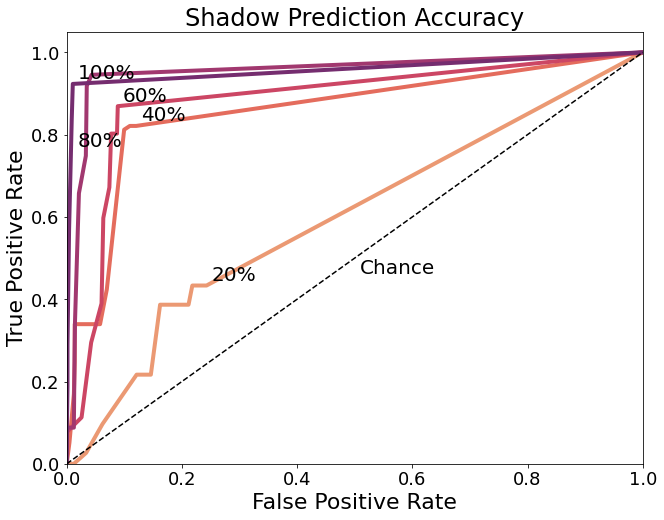

In [21]:
# testing sklearn ROC function
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc

ROC_dict = {}
libraries = [plot_dict_20, plot_dict_40, plot_dict_60, plot_dict_80, plot_dict_100]
colors = sns.color_palette("flare", len(libraries)*2)

labels = ['20%', '40%', '60%', '80%', '100%']

figureWidth = 10
figureHeight = 8
panelWidth = 8 / figureWidth
panelHeight = 6 / figureHeight

plt.figure(figsize=(figureWidth, figureHeight))
panel = plt.axes([0.1, 0.1, panelWidth, panelHeight])
prev_label = (0,0)
for i in range(len(libraries)):
    for read in libraries[i]:
        pred = libraries[i][read][1]
        true = libraries[i][read][0]
        true = [1 if i == 'y' else 0 for i in true]
        # RocCurveDisplay.from_predictions(true, pred)
        fpr, tpr, thresholds = roc_curve(true, pred)
        # do every other color
        # plt.plot(fpr, tpr, color=colors[i*2], label=f'library_{i}', alpha=0.2)
        ave_dict = {}
        for t in range(len(thresholds)):
            if thresholds[t] not in ave_dict:
                ave_dict[thresholds[t]] = [[fpr[t]], [tpr[t]]]
            else:
                ave_dict[thresholds[t]][0].append(fpr[t])
                ave_dict[thresholds[t]][1].append(tpr[t])
        
    x_mean = []
    y_mean = []
    for key in ave_dict:
        x_mean.append(np.mean(ave_dict[key][0]))
        y_mean.append(np.mean(ave_dict[key][1]))
    plt.plot(x_mean, y_mean, color=colors[i*2], label=f'library_{i}', linewidth=4)

    # Add annotation for the label at the middle of the curve
    # xy = (x_mean[len(x_mean) // 2], y_mean[len(y_mean) // 2 ] - 0.05) if labels[i] != '100%' else (x_mean[len(x_mean) // 2], x_mean[len(x_mean) // 2 ])
    # add annotation for the label at the second to last point of the curve
    xy = (x_mean[-2], y_mean[-2]) if labels[i] != '80%' else (x_mean[1], y_mean[-4])
    # make sure the label is not overlapping with the previous one and not overlapping with the curve
    if xy[0] - prev_label[0] < 0.01 and xy[1] - prev_label[1] < 0.01:
        xy = (xy[0] + 0.01, xy[1] + 0.01)
    prev_label = xy
    # add label to the curve
    panel.annotate(labels[i], xy=xy, xytext=(5, 5), textcoords='offset points', color='black', fontsize=20)

# plot chance line
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
panel.annotate('Chance', xy=(0.5, 0.45), xytext=(5, 5), textcoords='offset points', color='black', fontsize=20)
panel.set_xlim([0.0, 1.0])
panel.set_ylim([0.0, 1.05])
# set tick label size
panel.tick_params(axis='both', which='major', labelsize=18)
panel.set_xlabel('False Positive Rate', fontsize=22)
panel.set_ylabel('True Positive Rate', fontsize=22)

panel.set_title('Shadow Prediction Accuracy', fontsize=24)
plt.savefig('/data16/liam/testing/241210_roc_curve_kde.png', dpi=300)


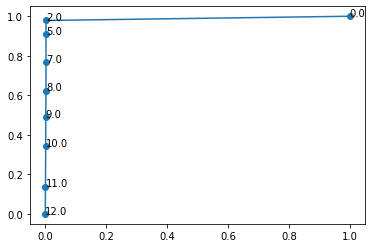

In [ ]:
# testing on one read
pred = plot_dict_100['read_0'][1]
true = plot_dict_100['read_0'][0]
true = [1 if i == 'y' else 0 for i in true]
fpr, tpr, thresholds = roc_curve(true, pred)
# set labels to each point
for i in range(len(fpr)):
    plt.text(fpr[i], tpr[i], thresholds[i])
plt.plot(fpr, tpr, '-o', label=thresholds)

In [21]:
reads_80 = parse_pred_file('/data16/liam/testing/241209_HMM_test_data_pred_80_kde.txt')

In [26]:
pred_dict = {}
for read in reads_100:
    # ic(read[1], read[4])
    read_dict, scores = p_ribosome(read[1], [read[4]], 1.0)
    pred_dict[read[0]] = read_dict
ic(pred_dict['read_0'])

ic| pred_dict['read_0']: {(103, 132): 9.0,
                          (409, 438): 8.0,
                          (609, 638): 11.0,
                          (937, 966): 10.0,
                          (1154, 1183): 10.0,
                          (1453, 1482): 8.0,
                          (1812, 1841): 2.0,
                          (2093, 2122): 11.0,
                          (2304, 2333): 10.0,
                          (2615, 2644): 6.0,
                          (2847, 2876): 5.0,
                          (3179, 3208): 9.0,
                          (3395, 3424): 7.0,
                          (3681, 3710): 7.0}


{(103, 132): 9.0,
 (409, 438): 8.0,
 (609, 638): 11.0,
 (937, 966): 10.0,
 (1154, 1183): 10.0,
 (1453, 1482): 8.0,
 (1812, 1841): 2.0,
 (2093, 2122): 11.0,
 (2304, 2333): 10.0,
 (2615, 2644): 6.0,
 (2847, 2876): 5.0,
 (3179, 3208): 9.0,
 (3395, 3424): 7.0,
 (3681, 3710): 7.0}

In [23]:
pred_dict_80 = {}
for read in reads_80:
    # ic(read[1], read[4])
    read_dict = p_ribosome(read[1], [read[4]], 0.8)
    pred_dict_80[read[0]] = read_dict

Text(0.5, 1.0, 'Confidence Score Distribution for Ribosome Prediction')

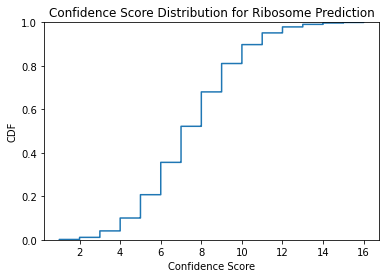

In [24]:
# plot distribution of confidence scores as CDF
import matplotlib.pyplot as plt
import seaborn as sns

confidence_scores = []
for read in pred_dict:
    for key in pred_dict[read]:
        confidence_scores.append(pred_dict[read][key])

# counts, bin_edges = np.histogram(confidence_scores, bins = 1000)
# pdf = counts/sum(counts)
# cdf = np.cumsum(pdf)
sns.ecdfplot(confidence_scores)
plt.xlabel('Confidence Score')
plt.ylabel('CDF')
plt.title('Confidence Score Distribution for Ribosome Prediction')


Text(0.5, 1.0, 'Confidence Score Distribution for Ribosome Prediction')

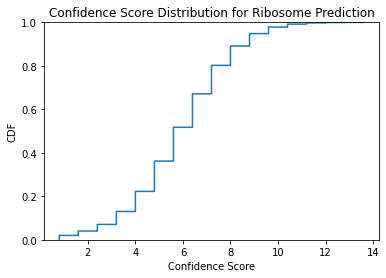

In [25]:
# plot distribution of confidence scores as CDF
import matplotlib.pyplot as plt
import seaborn as sns

confidence_scores_80 = []
for read in pred_dict_80:
    for key in pred_dict_80[read]:
        confidence_scores_80.append(pred_dict_80[read][key])

# counts, bin_edges = np.histogram(confidence_scores, bins = 1000)
# pdf = counts/sum(counts)
# cdf = np.cumsum(pdf)
sns.ecdfplot(confidence_scores_80)
plt.xlabel('Confidence Score')
plt.ylabel('CDF')
plt.title('Confidence Score Distribution for Ribosome Prediction')


In [26]:
# get min and max confidence scores
min_confidence = min(confidence_scores)
max_confidence = max(confidence_scores)
# get confidence score thresholds
confidence_thresholds = np.linspace(min_confidence, max_confidence, 100)
ic(confidence_thresholds)

ic| confidence_thresholds: array([ 1.        ,  1.15151515,  1.3030303 ,  1.45454545,  1.60606061,
                                   1.75757576,  1.90909091,  2.06060606,  2.21212121,  2.36363636,
                                   2.51515152,  2.66666667,  2.81818182,  2.96969697,  3.12121212,
                                   3.27272727,  3.42424242,  3.57575758,  3.72727273,  3.87878788,
                                   4.03030303,  4.18181818,  4.33333333,  4.48484848,  4.63636364,
                                   4.78787879,  4.93939394,  5.09090909,  5.24242424,  5.39393939,
                                   5.54545455,  5.6969697 ,  5.84848485,  6.        ,  6.15151515,
                                   6.3030303 ,  6.45454545,  6.60606061,  6.75757576,  6.90909091,
                                   7.06060606,  7.21212121,  7.36363636,  7.51515152,  7.66666667,
                                   7.81818182,  7.96969697,  8.12121212,  8.27272727,  8.42424242,
          

array([ 1.        ,  1.15151515,  1.3030303 ,  1.45454545,  1.60606061,
        1.75757576,  1.90909091,  2.06060606,  2.21212121,  2.36363636,
        2.51515152,  2.66666667,  2.81818182,  2.96969697,  3.12121212,
        3.27272727,  3.42424242,  3.57575758,  3.72727273,  3.87878788,
        4.03030303,  4.18181818,  4.33333333,  4.48484848,  4.63636364,
        4.78787879,  4.93939394,  5.09090909,  5.24242424,  5.39393939,
        5.54545455,  5.6969697 ,  5.84848485,  6.        ,  6.15151515,
        6.3030303 ,  6.45454545,  6.60606061,  6.75757576,  6.90909091,
        7.06060606,  7.21212121,  7.36363636,  7.51515152,  7.66666667,
        7.81818182,  7.96969697,  8.12121212,  8.27272727,  8.42424242,
        8.57575758,  8.72727273,  8.87878788,  9.03030303,  9.18181818,
        9.33333333,  9.48484848,  9.63636364,  9.78787879,  9.93939394,
       10.09090909, 10.24242424, 10.39393939, 10.54545455, 10.6969697 ,
       10.84848485, 11.        , 11.15151515, 11.3030303 , 11.45

In [27]:
# get min and max confidence scores
min_confidence_80 = min(confidence_scores_80)
max_confidence_80 = max(confidence_scores_80)
# get confidence score thresholds
confidence_thresholds_80 = np.linspace(min_confidence_80, max_confidence_80, 100)
ic(confidence_thresholds_80)

ic| confidence_thresholds_80: array([ 0.8       ,  0.92929293,  1.05858586,  1.18787879,  1.31717172,
                                      1.44646465,  1.57575758,  1.70505051,  1.83434343,  1.96363636,
                                      2.09292929,  2.22222222,  2.35151515,  2.48080808,  2.61010101,
                                      2.73939394,  2.86868687,  2.9979798 ,  3.12727273,  3.25656566,
                                      3.38585859,  3.51515152,  3.64444444,  3.77373737,  3.9030303 ,
                                      4.03232323,  4.16161616,  4.29090909,  4.42020202,  4.54949495,
                                      4.67878788,  4.80808081,  4.93737374,  5.06666667,  5.1959596 ,
                                      5.32525253,  5.45454545,  5.58383838,  5.71313131,  5.84242424,
                                      5.97171717,  6.1010101 ,  6.23030303,  6.35959596,  6.48888889,
                                      6.61818182,  6.74747475,  6.87676768,  7.006

array([ 0.8       ,  0.92929293,  1.05858586,  1.18787879,  1.31717172,
        1.44646465,  1.57575758,  1.70505051,  1.83434343,  1.96363636,
        2.09292929,  2.22222222,  2.35151515,  2.48080808,  2.61010101,
        2.73939394,  2.86868687,  2.9979798 ,  3.12727273,  3.25656566,
        3.38585859,  3.51515152,  3.64444444,  3.77373737,  3.9030303 ,
        4.03232323,  4.16161616,  4.29090909,  4.42020202,  4.54949495,
        4.67878788,  4.80808081,  4.93737374,  5.06666667,  5.1959596 ,
        5.32525253,  5.45454545,  5.58383838,  5.71313131,  5.84242424,
        5.97171717,  6.1010101 ,  6.23030303,  6.35959596,  6.48888889,
        6.61818182,  6.74747475,  6.87676768,  7.00606061,  7.13535354,
        7.26464646,  7.39393939,  7.52323232,  7.65252525,  7.78181818,
        7.91111111,  8.04040404,  8.16969697,  8.2989899 ,  8.42828283,
        8.55757576,  8.68686869,  8.81616162,  8.94545455,  9.07474747,
        9.2040404 ,  9.33333333,  9.46262626,  9.59191919,  9.72

In [28]:
def get_metrics(reads, confidence_dict, threshold):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    read_dict = {}
    for read in reads:
        read_name = read[0]
        predicted_sequence = read[1]
        true_sequence = read[2]
        modifications = read[3]
        true_footprints = get_all_footprint_indices(true_sequence)
        predicted_footprints = get_all_footprint_indices(predicted_sequence)
        # ic(confidence_dict[read_name])
        true_positives = get_true_positives(predicted_footprints, true_footprints, confidence_dict[read_name], threshold)
        false_positives = get_false_positives(predicted_footprints, true_footprints, confidence_dict[read_name], threshold)
        false_negatives = get_false_negatives(predicted_footprints, true_footprints)
        true_negatives = get_true_negatives(predicted_sequence, true_sequence)
        # normalize true_negatives by footprint size
        true_negatives = true_negatives / 30
        # # false positives are false if confidence score is below threshold or if there is no overlap with true footprints
        # false_positives = false_below + false_positives
        read_dict[read_name] = (true_positives, false_positives, false_negatives, true_negatives)
  
    return read_dict

In [29]:
pred_100_metrics = {}
for t in confidence_thresholds:
    pred_100_metrics[t] = get_metrics(reads_100, pred_dict, t)


In [30]:
pred_80_metrics = {}
for t in confidence_thresholds_80:
    pred_80_metrics[t] = get_metrics(reads_80, pred_dict_80, t)

In [31]:
ic(pred_80_metrics[0.8])

ic

| pred_80_metrics[0.8]: {'read_0': (20, 2, 0, 138.96666666666667),
                           'read_1': (4, 1, 0, 25.933333333333334),
                           'read_10': (5, 0, 0, 35.1),
                           'read_100': (10, 3, 0, 79.73333333333333),
                           'read_101': (13, 0, 0, 98.03333333333333),
                           'read_102': (3, 0, 0, 24.2),
                           'read_103': (5, 0, 0, 42.333333333333336),
                           'read_104': (17, 1, 0, 134.43333333333334),
                           'read_105': (18, 4, 0, 135.6),
                           'read_106': (8, 0, 0, 58.2),
                           'read_107': (13, 1, 0, 109.7),
                           'read_108': (18, 0, 0, 132.2),
                           'read_109': (6, 0, 0, 36.1),
                           'read_11': (4, 0, 0, 30.866666666666667),
                           'read_110': (5, 1, 0, 35.166666666666664),
                           'read_111': (13, 0, 0

{'read_0': (20, 2, 0, 138.96666666666667),
 'read_1': (4, 1, 0, 25.933333333333334),
 'read_2': (4, 1, 0, 26.466666666666665),
 'read_3': (7, 0, 0, 50.266666666666666),
 'read_4': (17, 0, 0, 116.83333333333333),
 'read_5': (2, 0, 0, 19.9),
 'read_6': (13, 1, 0, 97.96666666666667),
 'read_7': (8, 1, 0, 65.46666666666667),
 'read_8': (3, 0, 0, 26.5),
 'read_9': (16, 0, 0, 108.8),
 'read_10': (5, 0, 0, 35.1),
 'read_11': (4, 0, 0, 30.866666666666667),
 'read_12': (3, 2, 0, 19.0),
 'read_13': (6, 0, 0, 36.03333333333333),
 'read_14': (20, 0, 0, 140.83333333333334),
 'read_15': (2, 0, 0, 19.2),
 'read_16': (15, 1, 0, 117.8),
 'read_17': (4, 0, 0, 31.766666666666666),
 'read_18': (14, 0, 0, 112.2),
 'read_19': (18, 3, 0, 133.5),
 'read_20': (5, 0, 0, 33.233333333333334),
 'read_21': (4, 0, 0, 29.5),
 'read_22': (20, 1, 0, 129.1),
 'read_23': (11, 2, 0, 91.46666666666667),
 'read_24': (8, 0, 0, 76.96666666666667),
 'read_25': (14, 1, 0, 107.76666666666667),
 'read_26': (18, 0, 0, 125.53333333

In [32]:
def compute_ROC(metrics_dict):
    '''
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    '''
    ROC_dict = {}
    for t in metrics_dict:
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        for read in metrics_dict[t]:
            TP += metrics_dict[t][read][0]
            FP += metrics_dict[t][read][1]
            FN += metrics_dict[t][read][2]
            TN += metrics_dict[t][read][3]
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        ROC_dict[t] = (TPR, FPR)
        
    return ROC_dict

In [33]:
ROC_100 = compute_ROC(pred_100_metrics)

In [34]:
ROC_80 = compute_ROC(pred_80_metrics)

In [35]:
ic(ROC_80)

ic| ROC_80: {0.8: (0.9995331029974788, 0.009555673588118211),
             0.9292929292929293: (0.9995331029974788, 0.009555673588118211),
             1.0585858585858587: (0.9995331029974788, 0.009555673588118211),
             1.187878787878788: (0.9995331029974788, 0.009555673588118211),
             1.3171717171717172: (0.9995331029974788, 0.009555673588118211),
             1.4464646464646465: (0.9995331029974788, 0.009555673588118211),
             1.5757575757575757: (0.9995331029974788, 0.009555673588118211),
             1.7050505050505051: (0.9995305164319249, 0.007387655401943184),
             1.8343434343434344: (0.9995305164319249, 0.007387655401943184),
             1.9636363636363636: (0.9995305164319249, 0.007387655401943184),
             2.092929292929293: (0.9995305164319249, 0.007387655401943184),
             2.2222222222222223: (0.9995305164319249, 0.007387655401943184),
             2.3515151515151516: (0.9995305164319249, 0.007387655401943184),
             2.4

{0.8: (0.9995331029974788, 0.009555673588118211),
 0.9292929292929293: (0.9995331029974788, 0.009555673588118211),
 1.0585858585858587: (0.9995331029974788, 0.009555673588118211),
 1.187878787878788: (0.9995331029974788, 0.009555673588118211),
 1.3171717171717172: (0.9995331029974788, 0.009555673588118211),
 1.4464646464646465: (0.9995331029974788, 0.009555673588118211),
 1.5757575757575757: (0.9995331029974788, 0.009555673588118211),
 1.7050505050505051: (0.9995305164319249, 0.007387655401943184),
 1.8343434343434344: (0.9995305164319249, 0.007387655401943184),
 1.9636363636363636: (0.9995305164319249, 0.007387655401943184),
 2.092929292929293: (0.9995305164319249, 0.007387655401943184),
 2.2222222222222223: (0.9995305164319249, 0.007387655401943184),
 2.3515151515151516: (0.9995305164319249, 0.007387655401943184),
 2.480808080808081: (0.9995196926032661, 0.005965918290583819),
 2.61010101010101: (0.9995196926032661, 0.005965918290583819),
 2.7393939393939393: (0.9995196926032661, 0.0

In [36]:
ic(ROC_100)

ic| ROC_100: {1.0: (0.9997230684021047, 0.0),
              1.1515151515151516: (0.9997230684021047, 0.0),
              1.303030303030303: (0.9997230684021047, 0.0),
              1.4545454545454546: (0.9997230684021047, 0.0),
              1.606060606060606: (0.9997230684021047, 0.0),
              1.7575757575757576: (0.9997230684021047, 0.0),
              1.9090909090909092: (0.9997230684021047, 0.0),
              2.0606060606060606: (0.9997203579418344, 0.0),
              2.212121212121212: (0.9997203579418344, 0.0),
              2.3636363636363638: (0.9997203579418344, 0.0),
              2.515151515151515: (0.9997203579418344, 0.0),
              2.666666666666667: (0.9997203579418344, 0.0),
              2.8181818181818183: (0.9997203579418344, 0.0),
              2.9696969696969697: (0.9997203579418344, 0.0),
              3.121212121212121: (0.9997117047857006, 0.0),
              3.272727272727273: (0.9997117047857006, 0.0),
              3.4242424242424243: (0.999711704

{1.0: (0.9997230684021047, 0.0),
 1.1515151515151516: (0.9997230684021047, 0.0),
 1.303030303030303: (0.9997230684021047, 0.0),
 1.4545454545454546: (0.9997230684021047, 0.0),
 1.606060606060606: (0.9997230684021047, 0.0),
 1.7575757575757576: (0.9997230684021047, 0.0),
 1.9090909090909092: (0.9997230684021047, 0.0),
 2.0606060606060606: (0.9997203579418344, 0.0),
 2.212121212121212: (0.9997203579418344, 0.0),
 2.3636363636363638: (0.9997203579418344, 0.0),
 2.515151515151515: (0.9997203579418344, 0.0),
 2.666666666666667: (0.9997203579418344, 0.0),
 2.8181818181818183: (0.9997203579418344, 0.0),
 2.9696969696969697: (0.9997203579418344, 0.0),
 3.121212121212121: (0.9997117047857006, 0.0),
 3.272727272727273: (0.9997117047857006, 0.0),
 3.4242424242424243: (0.9997117047857006, 0.0),
 3.5757575757575757: (0.9997117047857006, 0.0),
 3.7272727272727275: (0.9997117047857006, 0.0),
 3.878787878787879: (0.9997117047857006, 0.0),
 4.03030303030303: (0.9996927174024378, 0.0),
 4.18181818181818

(0.0, 1.0)

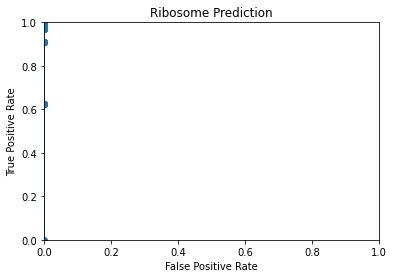

In [37]:
# plot ROC curve
TPR = [ROC_100[t][0] for t in ROC_100]
FPR = [ROC_100[t][1] for t in ROC_100]

plt.plot(FPR, TPR, '-o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ribosome Prediction')
plt.xlim(0, 1)
plt.ylim(0, 1)


(0.0, 1.0)

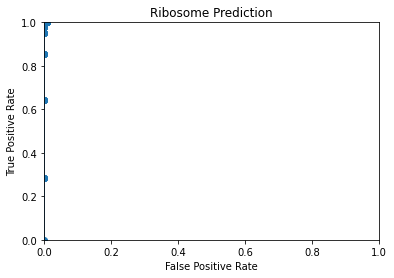

In [38]:
# plot ROC curve
TPR = [ROC_80[t][0] for t in ROC_80]
FPR = [ROC_80[t][1] for t in ROC_80]

plt.plot(FPR, TPR, '-o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ribosome Prediction')
plt.xlim(0, 1)
plt.ylim(0, 1)


In [11]:
reads_10 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_10_kde.txt')
reads_20 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_20_kde.txt')
reads_30 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_30_kde.txt')
reads_40 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_40_kde.txt')
reads_50 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_50_kde.txt')
reads_60 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_60_kde.txt')
reads_70 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_70_kde.txt')
reads_80 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_80_kde.txt')
reads_90 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_90_kde.txt')
reads_100 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_30only_kde.txt')

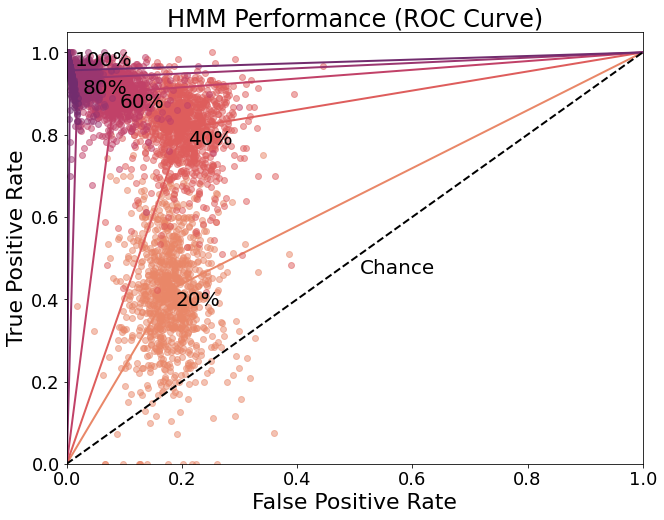

In [43]:
def plot_roc_curve_sklearn():
    from sklearn.metrics import roc_curve, auc, RocCurveDisplay
    import matplotlib.pyplot as plt
    import seaborn as sns

    true_positives = []
    false_positives = []

    # libraries = [reads_10, reads_20, reads_30, reads_40, reads_50, reads_60, reads_70, reads_80, reads_90, reads_100]
    libraries = [reads_20, reads_40, reads_60, reads_80, reads_100]
    import matplotlib.cm as cm
    colors = sns.color_palette("Greys", len(libraries))
    # labels = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
    labels = ['20%', '40%', '60%', '80%', '100%']

    figureWidth = 10
    figureHeight = 8
    panelWidth = 8 / figureWidth
    panelHeight = 6 / figureHeight

    plt.figure(figsize=(figureWidth, figureHeight))
    panel = plt.axes([0.1, 0.1, panelWidth, panelHeight])

    for reads, color, label in zip(libraries, colors, labels):
        all_true = []
        all_pred = []
        for read in reads:
            true_seq = read[2]
            pred_seq = read[1]
            true = np.array([1 if i == 'y' else 0 for i in true_seq])
            pred = np.array([1 if i == 'y' else 0 for i in pred_seq])

            all_true.append(true)
            all_pred.append(pred)

        all_true = np.concatenate(all_true)
        all_pred = np.concatenate(all_pred)
        fpr, tpr, _ = roc_curve(all_true, all_pred)
        roc_auc = auc(fpr, tpr)
        # ic(fpr, tpr)

        # panel.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
        panel.plot(fpr, tpr, color=color, lw=2, label=label)
        # panel = RocCurveDisplay.from_predictions(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    panel.legend(loc='lower right')
    panel.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    panel.set_xlim([0.0, 1.0])
    panel.set_ylim([0.0, 1.05])
    panel.set_xlabel('FPR', fontsize=18)
    panel.set_ylabel('TPR', fontsize=18)

    panel.set_title('ROC Curve Across Editing Efficiencies', fontsize=24)
    plt.savefig('/data16/liam/testing/roc_curve_kde.svg', dpi=300)

def plot_roc_curve_sklearn2():
    from sklearn.metrics import roc_curve, auc, RocCurveDisplay
    import matplotlib.pyplot as plt
    import seaborn as sns
    # libraries = [reads_10, reads_20, reads_30, reads_40, reads_50, reads_60, reads_70, reads_80, reads_90, reads_100]
    libraries = [reads_20, reads_40, reads_60, reads_80, reads_100]
    import matplotlib.cm as cm
    colors = sns.color_palette("flare", len(libraries))
    # labels = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
    labels = ['20%', '40%', '60%', '80%', '100%']

    figureWidth = 10
    figureHeight = 8
    panelWidth = 8 / figureWidth
    panelHeight = 6 / figureHeight

    plt.figure(figsize=(figureWidth, figureHeight))
    panel = plt.axes([0.1, 0.1, panelWidth, panelHeight]) 
    prev_label = (0,0)
    
    for reads, color, label in zip(libraries, colors, labels):
        all_true = []
        all_pred = []
        fpr_list = []
        tpr_list = []
        for read in reads:
            true_seq = read[2]
            pred_seq = read[1]
            true = np.array([1 if i == 'y' else 0 for i in true_seq])
            pred = np.array([1 if i == 'y' else 0 for i in pred_seq])

            all_true.append(true)
            all_pred.append(pred)
            # get fpr and tpr for each read
            fpr, tpr, _ = roc_curve(true, pred)
            fpr_list.append(fpr[1])
            tpr_list.append(tpr[1])

            

        all_true = np.concatenate(all_true)
        all_pred = np.concatenate(all_pred)
        fpr, tpr, _ = roc_curve(all_true, all_pred)
        # # ic(fpr, tpr, len(all_true), len(all_pred))
        # roc_auc = auc(fpr, tpr)
        # ic(fpr_list, tpr_list)
        
        panel.plot(fpr, tpr, color=color, lw=2, label=label)
        panel.plot(fpr_list, tpr_list, 'o', color=color, label=label, alpha=0.5)
        # Add annotation for the label at the middle of the curve
        xy = (fpr[len(fpr) // 2], tpr[len(tpr) // 2 ] - 0.05) if label != '100%' else (fpr[len(fpr) // 2], tpr[len(tpr) // 2 ])
        # make sure the label is not overlapping with the previous one and not overlapping with the curve
        if xy[0] - prev_label[0] < 0.01 and xy[1] - prev_label[1] < 0.01:
            xy = (xy[0] + 0.01, xy[1] + 0.01)
        prev_label = xy
        # if label is 80%, move it below the curve
        # if label == '80%':
        #     xy = (xy[0], xy[1] - 0.05)
        panel.annotate(label, xy=xy, xytext=(5, 5), textcoords='offset points', color='black', fontsize=20)
    panel.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Chance')
    panel.annotate('Chance', xy=(0.5, 0.45), xytext=(5, 5), textcoords='offset points', color='black', fontsize=20)
    panel.set_xlim([0.0, 1.0])
    panel.set_ylim([0.0, 1.05])
    # set tick label size
    panel.tick_params(axis='both', which='major', labelsize=18)
    panel.set_xlabel('False Positive Rate', fontsize=22)
    panel.set_ylabel('True Positive Rate', fontsize=22)

    panel.set_title('HMM Performance (ROC Curve)', fontsize=24)
    plt.savefig('/data16/liam/testing/roc_curve_kde.svg', dpi=300)


def plot_roc_curve_sklearn3():
    from sklearn.metrics import roc_curve, auc, RocCurveDisplay
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.optimize import curve_fit
    from scipy.interpolate import make_interp_spline
    # libraries = [reads_10, reads_20, reads_30, reads_40, reads_50, reads_60, reads_70, reads_80, reads_90, reads_100]
    libraries = [reads_20, reads_40, reads_60, reads_80, reads_100]
    import matplotlib.cm as cm
    colors = sns.color_palette("flare", len(libraries))
    # labels = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
    labels = ['20%', '40%', '60%', '80%', '100%']

    figureWidth = 10
    figureHeight = 8
    panelWidth = 8 / figureWidth
    panelHeight = 6 / figureHeight

    plt.figure(figsize=(figureWidth, figureHeight))
    panel = plt.axes([0.1, 0.1, panelWidth, panelHeight]) 
    prev_label = (0,0)
    
    for reads, color, label in zip(libraries, colors, labels):
        all_true = []
        all_pred = []
        fpr_list = []
        tpr_list = []
        for read in reads:
            true_seq = read[2]
            pred_seq = read[1]
            true = np.array([1 if i == 'y' else 0 for i in true_seq])
            pred = np.array([1 if i == 'y' else 0 for i in pred_seq])

            all_true.append(true)
            all_pred.append(pred)
            # get fpr and tpr for each read
            fpr, tpr, _ = roc_curve(true, pred)
            fpr_list.append(fpr[1])
            tpr_list.append(tpr[1])

        fpr_mean = np.mean(fpr_list)
        tpr_mean = np.mean(tpr_list)
        ic(fpr_mean, tpr_mean)
        # fit curve to mean [fpr_mean, tpr_mean], [0,0] and [1,1]
        fpr_x = np.array([0, fpr_mean, 1])
        tpr_y = np.array([0, tpr_mean, 1])
        
        X_Y_Spline = make_interp_spline(fpr_x, tpr_y)
        X_ = np.linspace(fpr_x.min(), fpr_x.max(), 100)
        Y_ = X_Y_Spline(X_)
        panel.plot(X_, Y_, color=color, lw=2, label=label)
        panel.plot(fpr_mean, tpr_mean, 'o', color=color)

        # Add annotation for the label at the middle of the curve
        xy = (fpr[len(fpr) // 2], tpr[len(tpr) // 2 ] - 0.05) if label != '100%' else (fpr[len(fpr) // 2], tpr[len(tpr) // 2 ])
        # make sure the label is not overlapping with the previous one and not overlapping with the curve
        if xy[0] - prev_label[0] < 0.01 and xy[1] - prev_label[1] < 0.01:
            xy = (xy[0] + 0.01, xy[1] + 0.01)
        prev_label = xy
        # if label is 80%, move it below the curve
        # if label == '80%':
        #     xy = (xy[0], xy[1] - 0.05)
        panel.annotate(label, xy=xy, xytext=(5, 5), textcoords='offset points', color='black', fontsize=20)
    panel.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Chance')
    panel.annotate('Chance', xy=(0.5, 0.45), xytext=(5, 5), textcoords='offset points', color='black', fontsize=20)
    panel.set_xlim([0.0, 1.0])
    panel.set_ylim([0.0, 1.05])
    # set tick label size
    panel.tick_params(axis='both', which='major', labelsize=18)
    panel.set_xlabel('False Positive Rate', fontsize=22)
    panel.set_ylabel('True Positive Rate', fontsize=22)

    panel.set_title('HMM Performance (ROC Curve)', fontsize=24)
    plt.savefig('/data16/liam/testing/roc_curve_kde.svg', dpi=300)


plot_roc_curve_sklearn2()

# ROC Curve from scratch bc WTF is sklearn doing
### referring to this: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

### pieces I need:
## classification threshold: Suppose the model scores one email as 0.99, predicting that email has a 99% chance of being spam, and another email as 0.51, predicting it has a 51% chance of being spam. If you set the classification threshold to 0.5, the model will classify both emails as spam. If you set the threshold to 0.95, only the email scoring 0.99 will be classified as spam.
### How to compute my P(Ribosome)? This needs to come out of the HMM. sequence context, modification rate. I need confidence/probability scores for footprint predictions. Diff thresholds will result in diff #'s of TPs, FPs, TNs, Fns
## TPR and FPR
### TPR = TP / TP + FN, FPR = TN / TN + FP
### TP = predicted footprint overlaps ground truth footprint (by at least 1 base?)
### FP = predicted footprint does not overlap a ground truth footprint
### TN = no predicted footprint and no ground truth footprint (I'm thinking this is all bases where there are no footprints anwhere)
### FN = no predicted footprint and there is a ground truth footprint



## Let's Make Some Accuracy Metrics

### Plot number of predictions vs number of ground truth ribosomes

In [20]:
def count_ribosome_footprints(predicted_data, ground_truth_data, footprint_char='y'):
    '''
    This functions counts the number of ribosome footprints in the predicted and ground truth data
    '''
    predicted_count = len([footprint for footprint in predicted_data.split('x') if footprint])
    ground_truth_count = len([footprint for footprint in ground_truth_data.split('x') if footprint])
    
    return predicted_count, ground_truth_count

In [21]:
def parse_pred_file(filename):
    reads = []
    with open(filename, 'r') as file:
        while True:
            read_name = file.readline().strip()
            if not read_name:
                break
            file.readline()  # Skip 'pred:' line
            predicted_sequence = file.readline().strip()
            file.readline()  # Skip 'true:' line
            true_sequence = file.readline().strip()
            file.readline()  # Skip 'modifications:' line
            modifications = file.readline().strip()
            reads.append((read_name, predicted_sequence, true_sequence, modifications))
    return reads

In [10]:
reads_100 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_30only_kde.txt')
read_footprint_100 = {}
# get footprint info for each read
for read in reads_100:
    read_footprint_100[read[0]] = count_ribosome_footprints(read[1], read[2])
# read_footprint_100

In [11]:
reads_80 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_80_kde.txt')
read_footprint_80 = {}
# get footprint info for each read
for read in reads_80:
    read_footprint_80[read[0]] = count_ribosome_footprints(read[1], read[2])

In [12]:
reads_50 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_50_kde.txt')
read_footprint_50 = {}
# get footprint info for each read
for read in reads_50:
    read_footprint_50[read[0]] = count_ribosome_footprints(read[1], read[2])

In [13]:
reads_DE50 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_AC50_kde.txt')
read_footprint_DE50 = {}
# get footprint info for each read
for read in reads_DE50:
    read_footprint_DE50[read[0]] = count_ribosome_footprints(read[1], read[2])

In [14]:
# plot number of reads where predicted footprint count is equal to ground truth footprint count
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

plot_dict = {'100%': None,
             '80%': None,
             '50%': None}
total_100 = len(read_footprint_100)
num_100 = 0

for read in read_footprint_100:
    if read_footprint_100[read][0] == read_footprint_100[read][1]:
        num_100 += 1

plot_dict['100%'] = (num_100, total_100)

total_80 = len(read_footprint_80)
num_80 = 0
for read in read_footprint_80:
    if read_footprint_80[read][0] == read_footprint_80[read][1]:
        num_80 += 1

plot_dict['80%'] = (num_80, total_80)

total_50 = len(read_footprint_50)
num_50 = 0

for read in read_footprint_50:
    if read_footprint_50[read][0] == read_footprint_50[read][1]:
        num_50 += 1

plot_dict['50%'] = (num_50, total_50)

total_DE50 = len(read_footprint_DE50)
num_DE50 = 0

for read in read_footprint_DE50:
    if read_footprint_DE50[read][0] == read_footprint_DE50[read][1]:
        num_DE50 += 1

plot_dict['DE50%'] = (num_DE50, total_DE50)

plot_dict

{'100%': (996, 1000),
 '80%': (382, 1000),
 '50%': (180, 999),
 'DE50%': (426, 1000)}

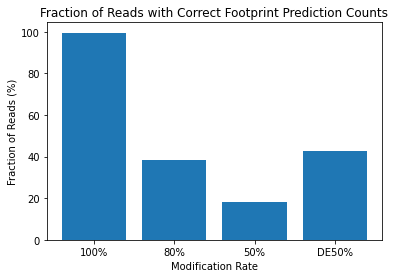

In [15]:
import matplotlib.pyplot as plt

# Extract the data from plot_dict
labels = list(plot_dict.keys())
values = [round((num / total) * 100, 2) for num, total in plot_dict.values()]

# Create the bar plot
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Modification Rate')
plt.ylabel('Fraction of Reads (%)')
plt.title('Fraction of Reads with Correct Footprint Prediction Counts')

# Show the plot
plt.savefig('/data16/liam/HMM_Scripts-1/figures/num_footprints.svg')


In [16]:
deviations = []
for read in read_footprint_100:
    diff = read_footprint_100[read][1] - read_footprint_100[read][0]
    deviations.append(diff)
dev_100 = np.mean(deviations)

deviations = []
for read in read_footprint_80:
    diff = read_footprint_80[read][1] - read_footprint_80[read][0]
    deviations.append(diff)
dev_80 = np.mean(deviations)

deviations = []
for read in read_footprint_50:
    diff = read_footprint_50[read][1] - read_footprint_50[read][0]
    deviations.append(diff)
dev_50 = np.mean(deviations)

deviations = []
for read in read_footprint_DE50:
    diff = read_footprint_DE50[read][1] - read_footprint_DE50[read][0]
    deviations.append(diff)
dev_DE50 = np.mean(deviations)

dev_100, dev_80, dev_50, dev_DE50

(0.004, -1.024, -1.5925925925925926, -0.198)

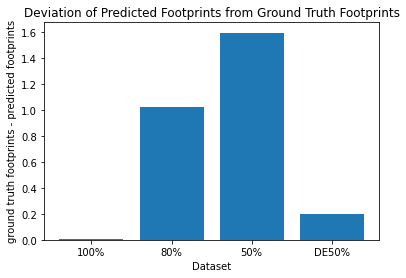

In [17]:
import matplotlib.pyplot as plt

# Create a list of dataset names
datasets = ['100%', '80%', '50%', 'DE50%']

# Create a list of deviations
deviations = [abs(dev_100), abs(dev_80), abs(dev_50), abs(dev_DE50)]

# Create the bar plot
plt.bar(datasets, deviations)

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('ground truth footprints - predicted footprints')
plt.title('Deviation of Predicted Footprints from Ground Truth Footprints')

# Show the plot
plt.savefig('/data16/liam/HMM_Scripts-1/figures/deviations.svg')


### Overlap of Footprints

In [22]:
def get_all_footprint_indices(data, footprint_char='y'):
    '''
    This function returns a list of tuples containing the start and end indices of all footprints in the data
    '''
    footprints = []
    start_index = None

    for i in range(len(data)):
        if data[i] == footprint_char and start_index is None:
            start_index = i
        elif data[i] != footprint_char and start_index is not None:
            footprints.append((start_index, i - 1))
            start_index = None

    if start_index is not None:
        footprints.append((start_index, len(data) - 1))

    return footprints

In [23]:
def calculate_overlap(predicted_start, predicted_end, ground_truth_start, ground_truth_end):
    '''
    calculates the overlap between two footprints
    '''
    overlap_start = max(predicted_start, ground_truth_start)
    overlap_end = min(predicted_end, ground_truth_end)
    
    if overlap_end >= overlap_start:
        overlap = overlap_end - overlap_start + 1
    else:
        overlap = 0
    
    return overlap

In [24]:
def count_overlapping_footprints(list1, list2):
    count = 0
    for footprint1 in list1:
        for footprint2 in list2:
            if footprint1[1] >= footprint2[0] and footprint1[0] <= footprint2[1]:
                count += 1
                break
    return count


In [21]:
overlap_100 = {}

for read in reads_100:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_100[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]
        

In [22]:
overlap_80 = {}

for read in reads_80:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_80[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]
            

In [23]:
overlap_50 = {}

for read in reads_50:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_50[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]



In [24]:
overlap_DE50 = {}

for read in reads_DE50:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_DE50[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]

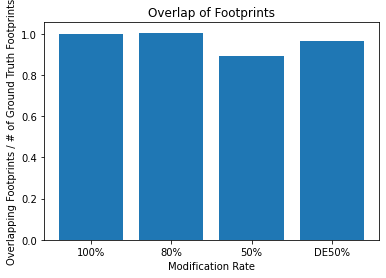

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# Extract the data from the overlap dictionaries
overlap_100_values = []
for read in overlap_100:
    overlap_100_values.append(overlap_100[read][0] / overlap_100[read][1])
overlap_100_values = np.mean(overlap_100_values)

overlap_80_values = []
for read in overlap_80:
    overlap_80_values.append(overlap_80[read][0] / overlap_80[read][1])
overlap_80_values = np.mean(overlap_80_values)

overlap_50_values = []
for read in overlap_50:
    overlap_50_values.append(overlap_50[read][0] / overlap_50[read][1])
overlap_50_values = np.mean(overlap_50_values)

overlap_DE50_values = []
for read in overlap_DE50:
    overlap_DE50_values.append(overlap_DE50[read][0] / overlap_DE50[read][1])
overlap_DE50_values = np.mean(overlap_DE50_values)


# Create the bar plot
plt.bar(['100%', '80%', '50%', 'DE50%'], [overlap_100_values, overlap_80_values, overlap_50_values, overlap_DE50_values])

# Add labels and title
plt.xlabel('Modification Rate')
plt.ylabel('Overlapping Footprints / # of Ground Truth Footprints')
plt.title('Overlap of Footprints')

# Show the plot
plt.savefig('/data16/liam/HMM_Scripts-1/figures/overlap.svg')


### Number of Predicted Footprints vs Number of Ground Truth Footprints #######

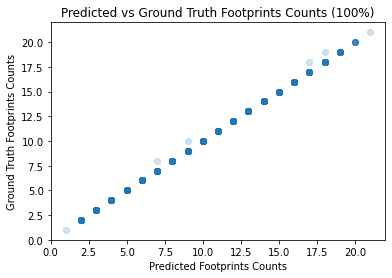

In [30]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []

for read in read_footprint_100:
    predicted_counts.append(read_footprint_100[read][0])
    ground_truth_counts.append(read_footprint_100[read][1])

# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts, alpha = 0.2)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (100%)')

# Show the plot
plt.savefig('/data16/liam/HMM_Scripts-1/figures/predicted_vs_ground_truth_100.svg')


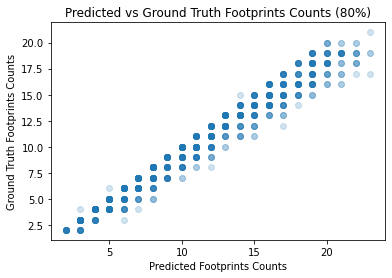

In [31]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []


for read in read_footprint_80:
    predicted_counts.append(read_footprint_80[read][0])
    ground_truth_counts.append(read_footprint_80[read][1])


# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts, alpha=0.2)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (80%)')

# Show the plot
plt.savefig('/data16/liam/HMM_Scripts-1/figures/predicted_vs_ground_truth_80.svg')


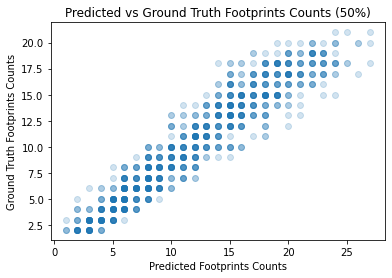

In [32]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []


for read in read_footprint_50:
    predicted_counts.append(read_footprint_50[read][0])
    ground_truth_counts.append(read_footprint_50[read][1])

# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts, alpha=0.2)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (50%)')

# Show the plot
plt.savefig('/data16/liam/HMM_Scripts-1/figures/predicted_vs_ground_truth_50.svg')


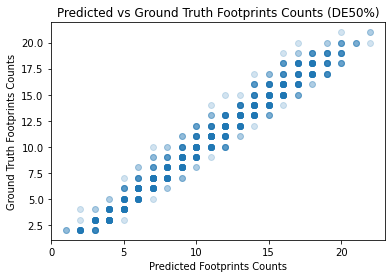

In [33]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []


for read in read_footprint_DE50:
    predicted_counts.append(read_footprint_DE50[read][0])
    ground_truth_counts.append(read_footprint_DE50[read][1])

# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts, alpha=0.2)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (DE50%)')

# Show the plot
plt.savefig('/data16/liam/HMM_Scripts-1/figures/predicted_vs_ground_truth_DE50.svg')


### Old Code, will probably delete 

In [ ]:
# need to create fake reads to insert dummy -1 values at non A positions
# mod_file = '/data16/liam/testing/HMM_test_data_30only.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_30only_pred.txt'
# emission_mat = [0.97, 0.03]
mod_file = '/data16/liam/testing/HMM_test_data_80.txt'
pred_file = '/data16/liam/testing/HMM_test_data_80_pred.txt'
# probability of linker mod, probability of footprint mod
emission_mat = [0.8, 0.03]
# mod_file = '/data16/liam/testing/HMM_test_data_50.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_50_pred.txt'
# emission_mat = [0.5, 0.5]
# mod_file = '/data16/liam/testing/HMM_test_data_25.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_25_pred.txt'
# emission_mat = [0.25, 0.75]
outDict = {}
with open (mod_file) as mf:
    with open(pred_file, 'w') as pf:
        mod_map, read_dict = build_modification_map(mf, emission_mat)
        
        
        for read, modList in mod_map.items():
            # check that edits and ground truth are same length
            assert len(read_dict[read][0]) == len(read_dict[read][1]), 'edits and ground truth are not the same length'

            read_length = len(read_dict[read][0])
            calling_vec = make_calling_vector(modList, read_length) 

            # initialize probability matrix
            prob_mat = np.array([[0.0] * 31 for _ in range(read_length+1)]) 
            
            # initialize pointer matrix
            ptr_mat = np.array([[-1] * 31 for _ in range(read_length+1)])
        

            initial_rate = 1 / 31.0
            log_initial_rate = math.log(initial_rate)


            for j in range(0,31):
                # initialize initial probability
                prob_mat[1][j] = log_initial_rate
                ptr_mat[1][j] = 0

            for i in range(1, read_length+1): # changed to 1, read_length+1 from 2, read_length + 1
                within_linker = 0.0
                back_frm_ribosome = 0.0
                # if i is not an A
                if calling_vec[i] == -1: # calling vector is -1 at non A positions
                    # within linker probability is same as previous
                    within_linker = prob_mat[i-1][0]
                    # if not in first row of matrix
                    if prob_mat[i-1][30] != 0:
                        back_frm_ribosome = prob_mat[i-1][30] 

                else:
                    # i is an A
                    k = int(calling_vec[i] * 100)
                    # if k == 97:
                    if k == emission_mat[0]*100: # mod
                        within_linker = math.log(k) + prob_mat[i-1][0]
                    # if k == 3:   
                    if k == emission_mat[1]*100: # no mod
                        if prob_mat[i-1][30] != 0:
                            back_frm_ribosome = math.log(k) + prob_mat[i-1][30]
                        
                #if probability that we are in the footprint is greater than the probability that we are in the linker
                if back_frm_ribosome != 0 and back_frm_ribosome > within_linker:
                    prob_mat[i][0] = back_frm_ribosome
                    ptr_mat[i][0] = 30 #update pointer matrix
                # if the probability that the previous nucleotide was in the linker is greater
                else:
                    prob_mat[i][0] = within_linker
                    ptr_mat[i][0] = 0

                if calling_vec[i] == -1:
                    prob_mat[i][1] = prob_mat[i - 1][0]
                else:
                    k = int(calling_vec[i] * 100)
                    # prob_mat[i][1] = log_norm_density(calling_vec[i], k, 0.03) + prob_mat[i - 1][0]
                    prob_mat[i][1] = math.log(k) + prob_mat[i - 1][0]
                ptr_mat[i][1] = 0

                for j in range(2, 31):
                    if calling_vec[i] == -1:
                        if prob_mat[i-1][j-1] != 0:
                            prob_mat[i][j] = prob_mat[i-1][j-1]
                    else:
                        k = int(calling_vec[i] * 100)
                        # k = 3
                        if prob_mat[i-1][j-1] != 0:
                            prob_mat[i][j] = math.log(k) + prob_mat[i-1][j-1]
                            # prob_mat[i][j] = log_norm_density(calling_vec[i], k, 0.03) + prob_mat[i-1][j-1]
                    if prob_mat[i][j] != 0:
                        ptr_mat[i][j] = j-1
            
            # set max probability to super low number
            max_prob = -10000000.0
            # set max index to -1, which will be used to index the backtrack vector
            max_index = -1
            # iterate through the last row of the probability matrix to find the max probability
            for j in range(31):
                # if the probability of the last nucleotide being in the ribosome is greater than the max probability
                if prob_mat[read_length][j] > max_prob:
                    # set the max probability to the probability of the last nucleotide being in the ribosome
                    max_prob = prob_mat[read_length][j]
                    # set the max index to the index of the last nucleotide being in the ribosome
                    max_index = j
            
            # initialize backtrack vector
            backtrack_vec = []
            # for i in range(read_length, 0, -1):
            for i in range(len(ptr_mat)-1, 0, -1):
                # append the max index to the backtrack vector
                backtrack_vec.append(max_index)
                # set the max index to the index of the previous nucleotide
                max_index = ptr_mat[i-1][max_index] # added ptr_mat[i-1][max_index] instead of ptr_mat[i][max_index], Dec 21, 2023
            # reverse the backtrack vector
            backtrack_vec.reverse()
            
            pred = ''
            
            for i in range(len(backtrack_vec)):
                if backtrack_vec[i] > 0:
                    pred += 'y'
                else:
                    pred += 'x'

            # #### Refine the prediction ####
            # edits = read_dict[read][0]
            # # print('read: ' + read)
            # # print('unrefined pred: ')
            # # print(pred)
            # for i in range(len(pred)):
            #     if pred[i] == 'y':
            #         # get footprint length
            #         footprint_length = 1
            #         while pred[i+footprint_length] == 'y' and footprint_length <= 30:
            #             footprint_length += 1
            #         block = pred[i:i+footprint_length]
            #         edit_block = edits[i:i+len(block)]
            #         # if there is an edit in the footprint
            #         if 1 in edit_block:
            #             # if the edit is in the first half of the footprint
            #             if edit_block[:len(edit_block)//2].count(1) > 0:
            #                 # shift the footprint to the right
            #                 shift = 1
            #                 while pred[i+shift] == 'y':
            #                     if edits[i+shift:i+shift+footprint_length].count(1) > 0:
            #                         shift += 1
            #                     else:
            #                         break
            #                 pred = pred[:i] + 'x'*shift + block + pred[i+shift+footprint_length:]
            #             # if the edit is in the second half of the footprint
            #             elif edit_block[len(edit_block)//2:].count(1) > 0:
            #                 # shift the footprint to the left
            #                 shift = 1
            #                 while pred[i+footprint_length-shift] == 'y':
            #                     if edits[i-shift:i-shift+footprint_length].count(1) > 0:
            #                         shift += 1
            #                     else:
            #                         break
            #                     shift += 1
            #                 pred = pred[:i-shift] + block + 'x'*shift + pred[i+footprint_length:]

                    # print('pred: ' )
                    # print(pred)
                    # print('true: ')
                    # print(read_dict[read][1])
                    # print('modifications: ')
                    # print(''.join(str(i) for i in read_dict[read][0]))
                    
                    # assert len(pred) == len(read_dict[read][1]), 'prediction and ground truth are not the same length'
            if len(pred) != len(read_dict[read][1]):
                print('prediction and ground truth are not the same length')
                print('pred: ')
                print(pred)
                print('true: ')
                print(read_dict[read][1])
                sys.exit()
            outDict[read] = [pred, read_dict[read][1]]

            
            # assert len(pred) == len(read_dict[read][1]), 'prediction and ground truth are not the same length' 
            # print('pred:')
            # print(pred)
            # print('true:')
            # print(read_dict[read][1])
            # print('modifications:')
            # print(''.join(str(i) for i in read_dict[read][0]))
            
            #### write transition matrix to file ####
            # with open('/data16/liam/testing/transition_mat.txt', 'w') as tm:
            #     tm.write('read_length: ' + str(len(read_dict[read][1])) + '\t' + 'prediction_length: ' + str(len(pred)) + '\t' + 
            #              'matrix_length: ' + str(ptr_mat.shape[0]) + '\t'+ 'backtrack_vec: ' + str(len(backtrack_vec)) + '\n')
            #     tm.write(read)
            #     tm.write('\n')
            #     tm.write('\t'.join(str(i) for i in ptr_mat[0]))
            #     tm.write('\n')
            #     tm.write('\t'.join(str(i) for i in ptr_mat[1]) + '\t' + str(calling_vec[0]) + '\t' + read_dict[read][1][0] + '\t' + pred[0] + '\t' + str(backtrack_vec[0]))
            #     tm.write('\n')
            #     for j in range(1, len(ptr_mat)):
            #         tm.write('\t'.join(str(i) for i in ptr_mat[j]) + '\t' + str(calling_vec[j]) + '\t' + read_dict[read][1][j-1] + '\t' + pred[j-1] + '\t' + str(backtrack_vec[j-1]))
            #         tm.write('\n')

            #### write prediction to file ####
            pf.write(read + '\n')
            pf.write('pred:' + '\n')
            pf.write(pred + '\n')
            pf.write('true:' + '\n')
            pf.write(read_dict[read][1] + '\n')
            pf.write('modifications:' + '\n')
            pf.write(''.join(str(i) for i in read_dict[read][0]) + '\n')


                
        #### backtracking to produce bed coordinates ####
        # # initialize variables to hold the start and end of the ribosome
        # rib_start = 0
        # rib_end = 0
        # InRibosome = False
        # print(backtrack_vec)
        # for i in range(len(backtrack_vec)):
        #     if backtrack_vec[i] > 0:
        #         if not InRibosome:
        #             # if the nucleotide is in the ribosome and the previous nucleotide was not in the ribosome
                    
        #             rib_start = i + 1
        #             pred += 'x'*(i-rib_end)
        #             InRibosome = True
        #     else:
        #         if InRibosome:
        #             # if the nucleotide is not in the ribosome and the previous nucleotide was in the ribosome
        #             rib_end = i + 1 
        #             pred += 'y'*(rib_end-i)
        #             InRibosome = False
        # if InRibosome:
        #     pred += 'y'*backtrack_vec[i]
